## Importing Required Dependencies

In [121]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Model

from skimage.io import imread, imshow
from skimage.transform import resize

import os
from tqdm import tqdm
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## HyperParameters

In [7]:
img_width = 128
img_height = 128
img_channels = 3

## Process the data

In [114]:
train_path  = 'stage1_train'
test_path = 'stage1_test'

train_ids = os.listdir(train_path)
test_ids = os.listdir(test_path)

X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype = np.bool_)

X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype = np.uint8)

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = train_path + '/'+ id_
    img = imread(path + '/images/'  + id_ + '.png')[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode = 'constant', preserve_range = True)
    X_train[n] = img

    mask = np.zeros((img_height, img_width, 1), dtype = np.bool_)
    
    for mask_file in os.listdir(path +  '/masks/'):
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode = 'constant',
                                     preserve_range = True), axis = -1)
        mask  = np.maximum(mask, mask_)

    Y_train[n] = mask

print('Resizing Test images')
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = test_path  + '/' + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode = 'constant', preserve_range=True)
    X_test[n] = img 

print('Data Loaded Successfully!')

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [11:35<00:00,  1.04s/it]


Resizing Test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 20.89it/s]

Data Loaded Successfully!


## Display the data

<function matplotlib.pyplot.show(close=None, block=None)>

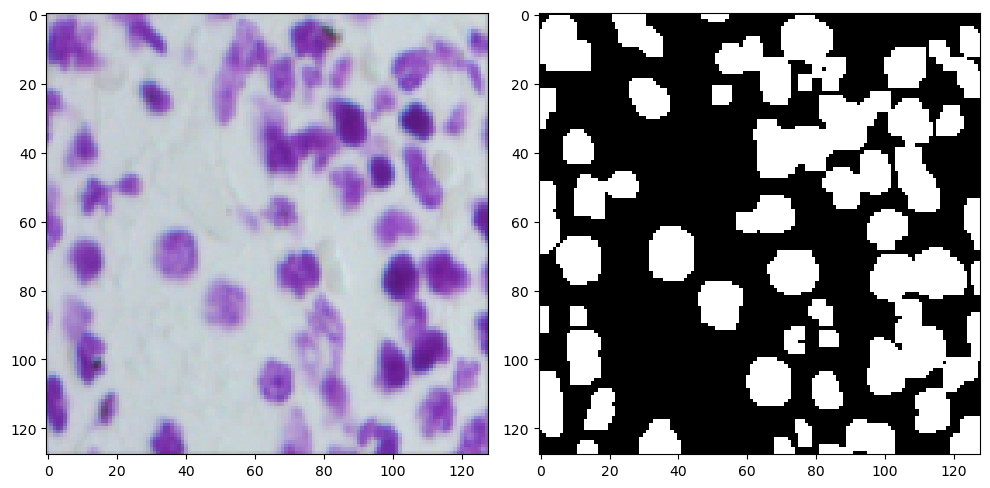

In [162]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
imshow(X_train[3])
plt.subplot(1,2,2)
imshow(np.squeeze(Y_train[3]))
plt.show

## Build the Unet Model

In [163]:
inputs = Input(shape = (img_width, img_height, img_channels), name = 'Input')

s = Lambda(lambda x : x/255)(inputs)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [17]:
#model.summary()

In [164]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

### Callbacks

In [165]:
checkpoints = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='logs', )
]

## Fit the model

In [166]:
unet_history = model.fit(X_train, Y_train,
                        validation_split = 0.1,
                        batch_size = 16,
                        epochs = 25,
                        callbacks=callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 0.5765 - val_loss: 0.2776
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 0.2926 - val_loss: 0.2028
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.1937 - val_loss: 0.1366
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.1430 - val_loss: 0.1154
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - loss: 0.1324 - val_loss: 0.1150
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.1171 - val_loss: 0.0972
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.1081 - val_loss: 0.1033
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.1072 - val_loss: 0.1082
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.1043 - val_loss: 0.0941
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 0.0944 - val_loss: 0.0929
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.1067 - val_loss: 0.0904
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 0.1073 - val_lo

## Display of Model Losses

In [256]:
history_dataframe = pd.DataFrame({'Training Loss' : unet_history.history['loss'],
                                  'Validation Loss' : unet_history.history['val_loss']})

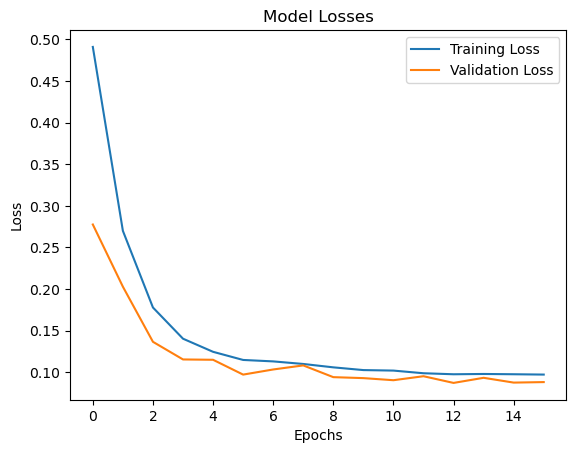

In [264]:
plt.plot(unet_history.history['loss'], label = 'Training Loss')
plt.plot(unet_history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Prediction

In [167]:
idx = random.randint(0, len(X_train))

In [168]:
preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_tests = model.predict(X_test, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 630ms/step


In [173]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_tests > 0.5).astype(np.uint8)

## Display the Predicted Masks

### Training Masks

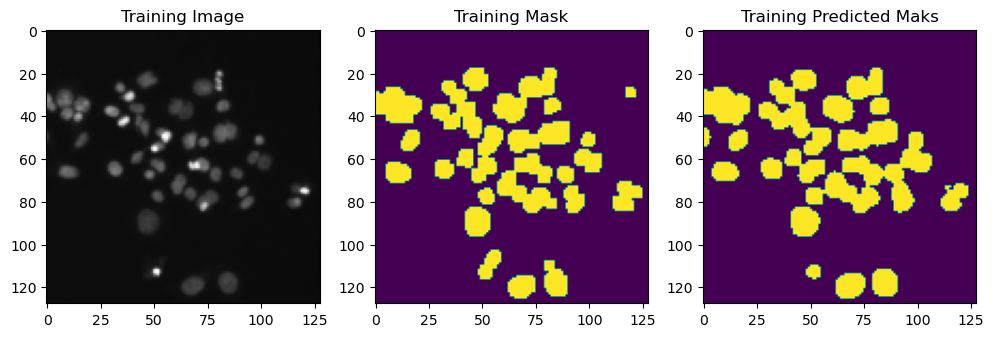

In [265]:
ix = random.randint(0, len(preds_train_t-1))
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(X_train[ix])
axes[0].set_title('Training Image')

axes[1].imshow(np.squeeze(Y_train[ix]))
axes[1].set_title('Training Mask')

axes[2].imshow(np.squeeze(preds_train_t[ix]))
axes[2].set_title('Training Predicted Maks')
plt.savefig('Results\Training.png')
plt.show()

### Validation Masks

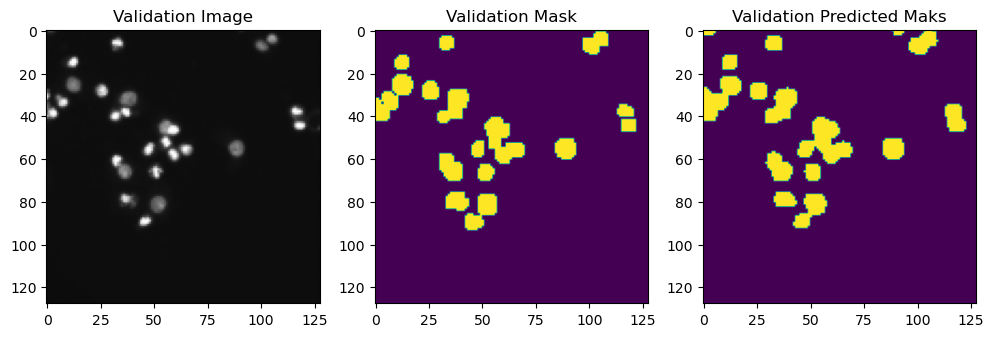

In [266]:
ix = random.randint(0, len(preds_val_t-1))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(X_train[int(X_train.shape[0] * 0.9):][ix])
axes[0].set_title('Validation Image')

axes[1].imshow(np.squeeze(Y_train[int(X_train.shape[0] * 0.9):][ix]))
axes[1].set_title('Validation Mask')

axes[2].imshow(np.squeeze(preds_val_t[ix]))
axes[2].set_title('Validation Predicted Maks')
plt.savefig('Results\Validation.png')
plt.show()

### Testing Masks

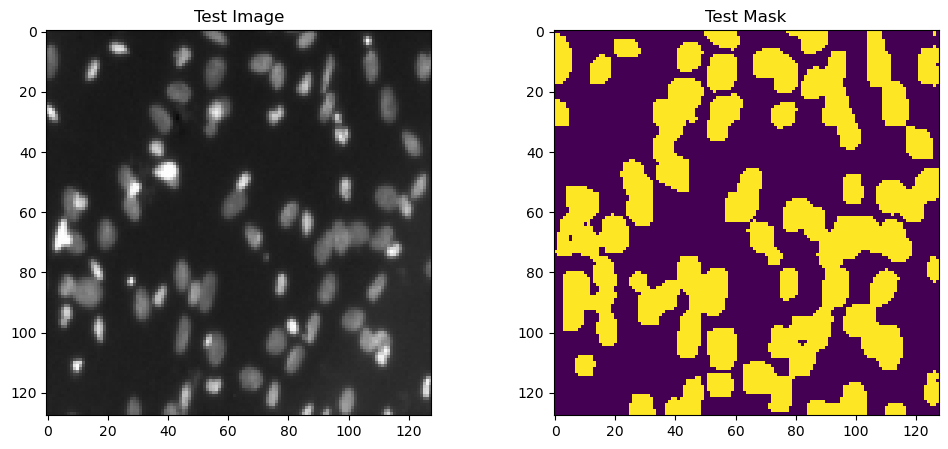

In [267]:
ix = random.randint(0, len(preds_test_t-1))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(X_test[ix])
axes[0].set_title('Test Image')

axes[1].imshow(np.squeeze(preds_test_t[ix]))
axes[1].set_title('Test Mask')
plt.savefig('Results\Testing.png')
plt.show()